# Transfer Learning: Scaling up 

What we're going to cover:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of Food Vision model trained on 10% of the training data
  - Finding model's most wrong predictions
- Making predictions with Food Vision model on custom images of food


## Creating helper functions


In [10]:
# Get helper functions file
!wget https://github.com/karan1384/Data-Science-Challenge/blob/main/Data-Science-Challenege/Data/helper_functions.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

In [1]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_per

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.



## Train a big dog model with transfer learning on 10% of 101 food classes

Start by creating the `ModelCheckpoint` callback. 



In [8]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")


In [10]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 29s 59ms/step - loss: 3.3881 - accuracy: 0.2796 - val_loss: 2.4697 - val_accuracy: 0.4661
Epoch 2/5
237/237 [==============================] - 12s 51ms/step - loss: 2.1996 - accuracy: 0.4937 - val_loss: 2.0252 - val_accuracy: 0.5188
Epoch 3/5
237/237 [==============================] - 12s 51ms/step - loss: 1.8245 - accuracy: 0.5675 - val_loss: 1.8783 - val_accuracy: 0.5344
Epoch 4/5
237/237 [==============================] - 12s 50ms/step - loss: 1.6061 - accuracy: 0.6055 - val_loss: 1.8206 - val_accuracy: 0.5355
Epoch 5/5
237/237 [==============================] - 11s 48ms/step - loss: 1.4493 - accuracy: 0.6440 - val_loss: 1.7824 - val_accuracy: 0.5310


In [13]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 16s 21ms/step - loss: 1.5888 - accuracy: 0.5797


[1.5887829065322876, 0.5797227621078491]

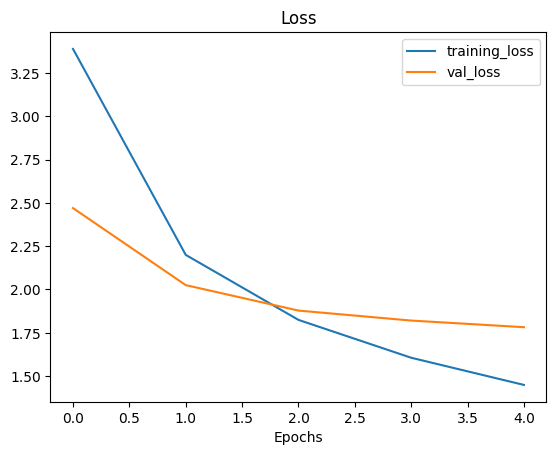

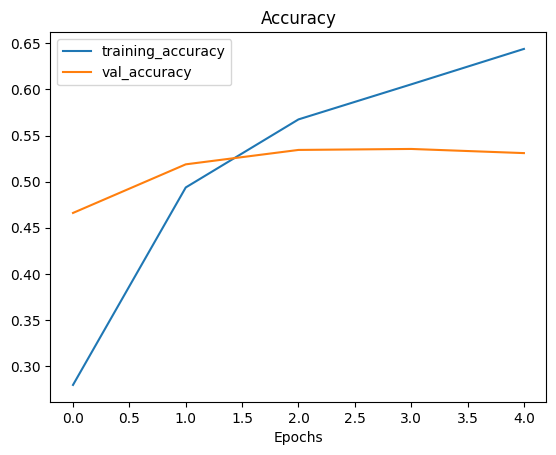

In [14]:
plot_loss_curves(history_all_classes_10_percent)

If the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

### Fine-tuning

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

Model recompiled, how about we make sure the layers we want are trainable?

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 51s 173ms/step - loss: 1.2195 - accuracy: 0.6764 - val_loss: 1.7268 - val_accuracy: 0.5392
Epoch 6/10
237/237 [==============================] - 25s 104ms/step - loss: 1.1019 - accuracy: 0.7006 - val_loss: 1.7007 - val_accuracy: 0.5493
Epoch 7/10
237/237 [==============================] - 22s 91ms/step - loss: 1.0089 - accuracy: 0.7291 - val_loss: 1.7452 - val_accuracy: 0.5426
Epoch 8/10
237/237 [==============================] - 20s 84ms/step - loss: 0.9453 - accuracy: 0.7480 - val_loss: 1.7133 - val_accuracy: 0.5506
Epoch 9/10
237/237 [==============================] - 19s 79ms/step - loss: 0.8790 - accuracy: 0.7673 - val_loss: 1.7370 - val_accuracy: 0.5471
Epoch 10/10
237/237 [==============================] - 17s 72ms/step - loss: 0.8351 - accuracy: 0.7768 - val_loss: 1.7431 - val_accuracy: 0.5498


In [20]:
# Evaluate fine-tuned model on test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 16s 21ms/step - loss: 1.5078 - accuracy: 0.6011


[1.5077574253082275, 0.6010693311691284]

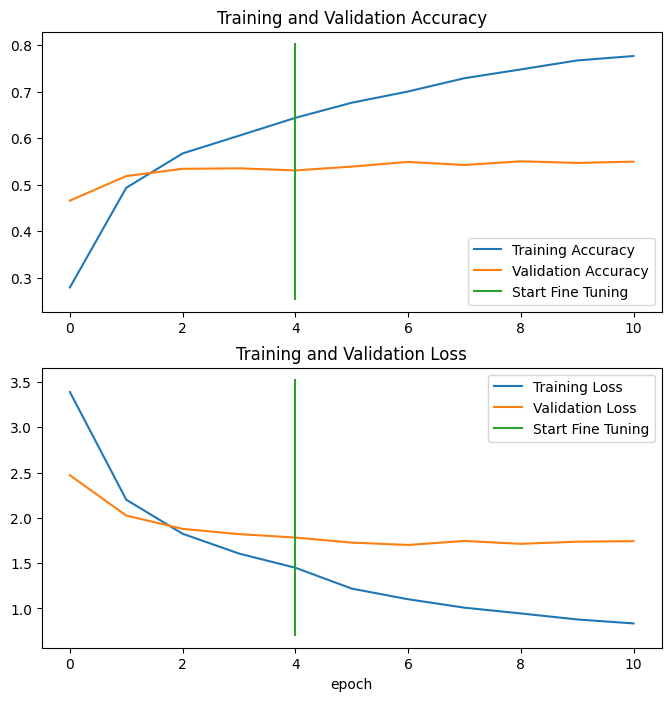

In [21]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Evaluating the performance of the big dog model across all different classes


In [14]:
import tensorflow as tf

import zipfile

zip_ref = zipfile.ZipFile("06_101_food_class_10_percent_saved_big_dog_model.zip", "r")
zip_ref.extractall()
zip_ref.close()

saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [24]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 19s 22ms/step - loss: 1.8022 - accuracy: 0.6078


(1.8021684885025024, 0.6078019738197327)

### Making predictions with our trained model


In [25]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 15s 18ms/step


In [26]:
# How many predictions are there?
len(pred_probs)

25250

In [27]:
# What's the shape of predictions?
pred_probs.shape

(25250, 101)

In [28]:
# How do they look?
pred_probs[:10]

array([[5.9555572e-02, 3.5662119e-06, 4.1279349e-02, ..., 1.4194699e-09,
        8.4039129e-05, 3.0820314e-03],
       [9.6338320e-01, 1.3765826e-09, 8.5042708e-04, ..., 5.4804143e-05,
        7.8341188e-12, 9.7811304e-10],
       [9.5942634e-01, 3.2432759e-05, 1.4769287e-03, ..., 7.1438910e-07,
        5.5323352e-07, 4.0179562e-05],
       ...,
       [4.7279873e-01, 1.2954312e-07, 1.4748254e-03, ..., 5.9630687e-04,
        6.7163957e-05, 2.3532135e-05],
       [4.4502247e-02, 4.7261000e-07, 1.2174438e-01, ..., 6.2917384e-06,
        7.5576504e-06, 3.6633476e-03],
       [7.2373080e-01, 1.9256416e-09, 5.2089705e-05, ..., 1.2218992e-03,
        1.5755526e-09, 9.6206924e-05]], dtype=float32)

In [29]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95555715e-02 3.56621194e-06 4.12793495e-02 1.06392506e-09
 8.19964274e-09 8.61560245e-09 8.10409119e-07 8.49006710e-07
 1.98095986e-05 7.99297993e-07 3.17695403e-09 9.83702989e-07
 2.83578265e-04 7.78589082e-10 7.43659853e-04 3.87942600e-05
 6.44463080e-06 2.50333073e-06 3.77276956e-05 2.05599179e-07
 1.55429479e-05 8.10427650e-07 2.60885736e-06 2.03088433e-07
 8.30327224e-07 5.42988437e-06 3.74273668e-06 1.32360203e-08
 2.74555851e-03 2.79426695e-05 6.86718571e-10 2.53517483e-05
 1.66382728e-04 7.57455043e-10 4.02367179e-04 1.30578828e-08
 1.79280721e-06 1.43956686e-06 2.30789818e-02 8.24019480e-07
 8.61712351e-07 1.69789450e-06 7.03542946e-06 1.85722051e-08
 2.87577478e-07 7.99586633e-06 2.07466110e-06 1.86462174e-07
 3.34909487e-08 3.17168073e-04 1.04948031e-05 8.55388123e-07
 8.47566068e-01 1.05432355e-05 4.34703423e-07 3.72825380e-05
 3.50601949e-05 3.25856490e-05 6.74493349e-

In [30]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [31]:
# This might take a time
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
len(y_labels)

25250

### Evaluating our models predictions


In [33]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6078019801980198

In [34]:
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: -6.378287120689663e-09


In [35]:
from helper_functions import make_confusion_matrix

In [36]:

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [54]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [38]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.44      0.55       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.52       250
          10       0.62      0.42      0.50       250
          11       0.83      0.48      0.61       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [58]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7315436241610739,
  'recall': 0.436,
  'f1-score': 0.5463659147869674,
  'support': 250},
 '5': {'precision': 0.3426395939086294,
  'recall': 0.54,
  'f1-score': 0.4192546583850932,
  'support': 250},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.724264705882353,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9':

In [41]:
# Create empty dictionary
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": 
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5463659147869674,
 'beet_salad': 0.4192546583850932,
 'beignets': 0.724264705882353,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5152224824355972,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6126582278481012,
 'cannoli': 0.6115702479338843,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42689075630252105,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3255813953488372,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brule

In [59]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
33,edamame,0.935361
63,macarons,0.895397
75,pho,0.869903
91,spaghetti_carbonara,0.847656
69,oysters,0.834008


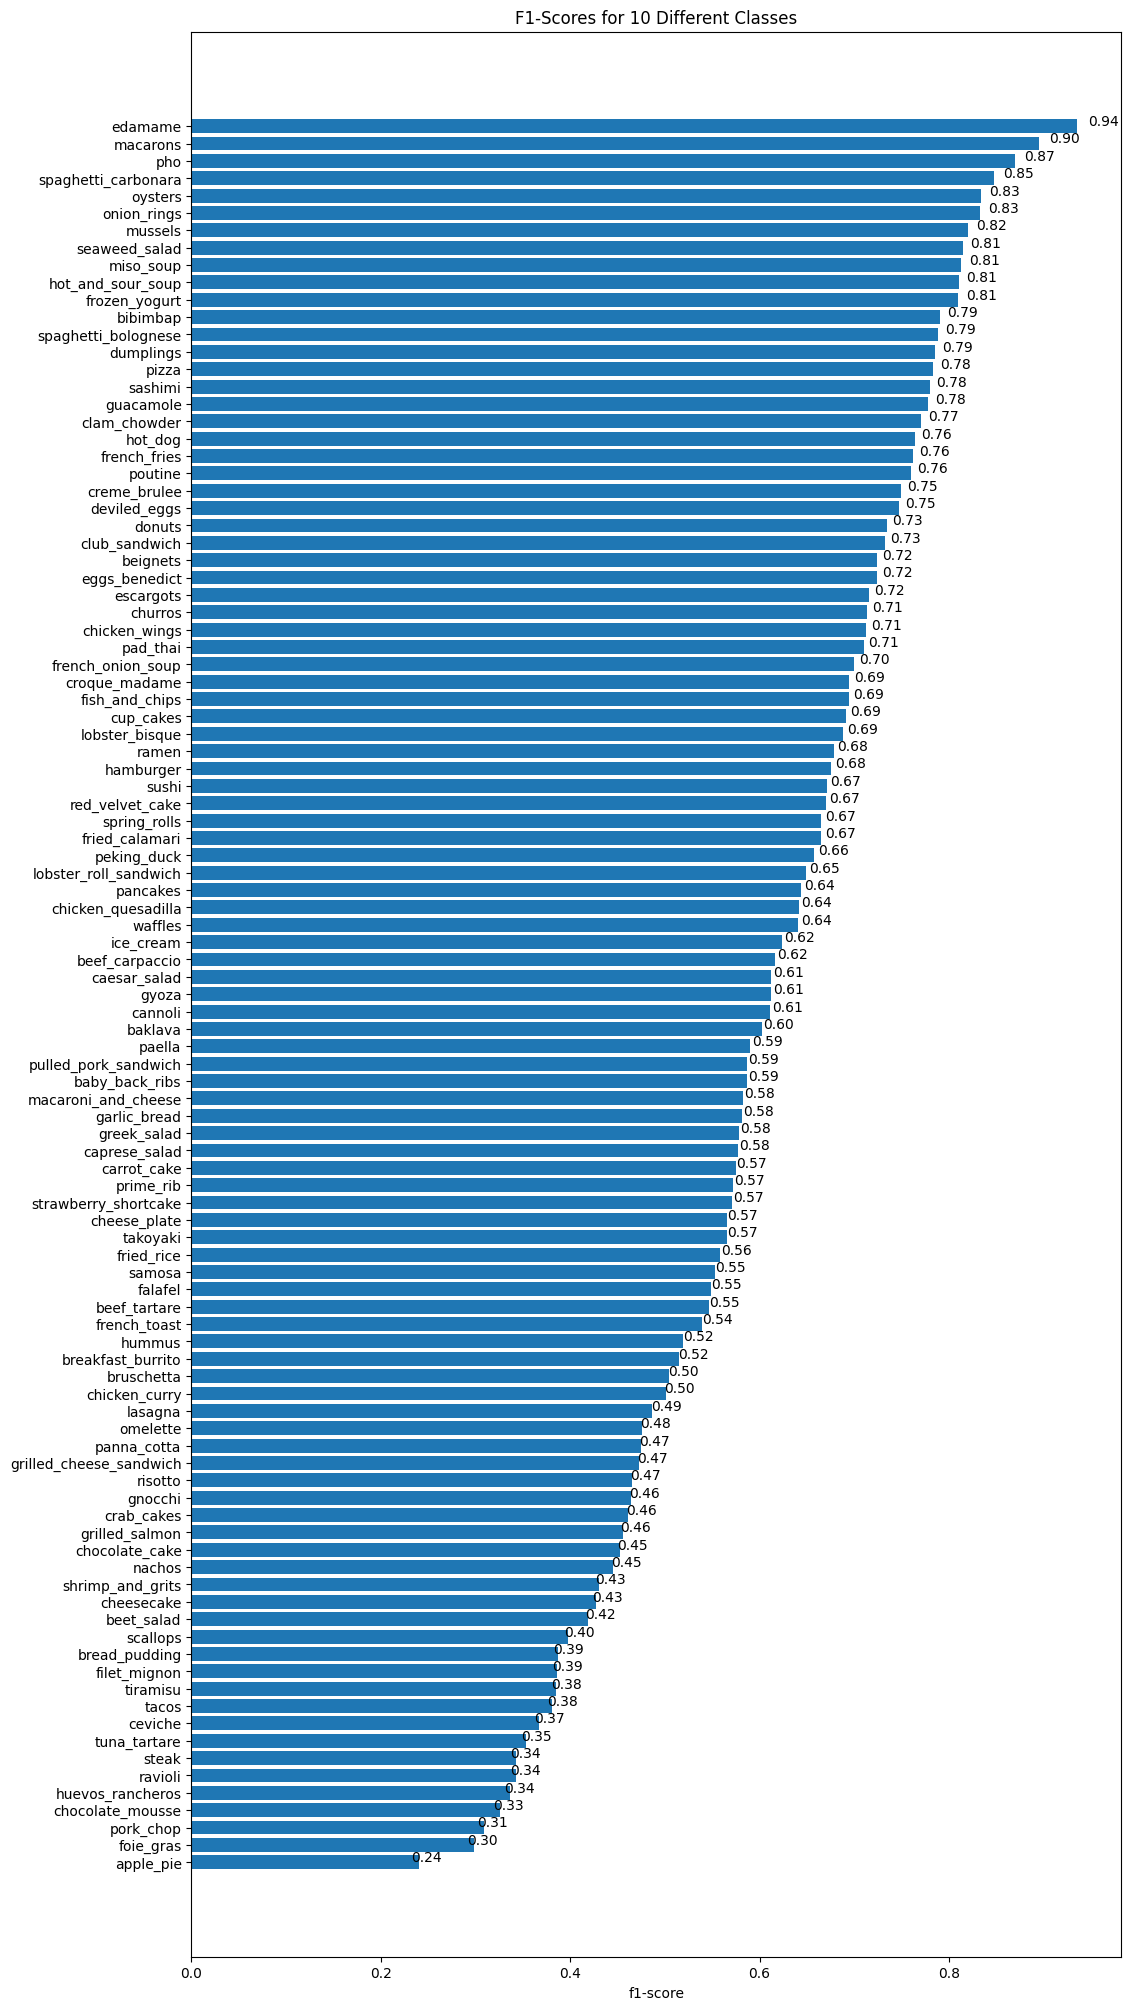

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); 

def autolabel(rects): 
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Visualizing predictions on test images


In [44]:
def load_and_prep_image(filename, img_shape=224, scale=True):
 
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to: 

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

In [15]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

NameError: name 'plt' is not defined

### Finding the most wrong predictions

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [46]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:
* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names. 

In [47]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), 
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847566,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.963383,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959426,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.656333,apple_pie,pulled_pork_sandwich
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.364707,apple_pie,prime_rib


In [48]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847566,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.963383,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959426,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.656333,apple_pie,pulled_pork_sandwich,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.364707,apple_pie,prime_rib,False


In [49]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.999997,scallops,cup_cakes,False
231,b'101_food_classes_10_percent/test/apple_pie/8...,0,100,0.999995,apple_pie,waffles,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'101_food_classes_10_percent/test/samosa/3140...,85,92,0.999982,samosa,spring_rolls,False
24540,b'101_food_classes_10_percent/test/tiramisu/16...,98,83,0.999946,tiramisu,red_velvet_cake,False
2511,b'101_food_classes_10_percent/test/bruschetta/...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'101_food_classes_10_percent/test/chocolate_m...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.999930,paella,mussels,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.999904,sushi,sashimi,False


In [17]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row 
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

NameError: name 'plt' is not defined